# ELMo Contextual Embeddings

In this notebook, we use contextual embeddings from ELMo to study semantic change of conversion.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition
import random

import src.corpus
import src.semantic_embedding

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Parse the corpus

In [2]:
#UD_FILE = "../data/en_ewt-ud-train.conllu"
#corpus = src.corpus.POSCorpus.create_from_ud(data_file_path=UD_FILE)

BNC_FILE = "../data/bnc/bnc.pkl"
corpus = src.corpus.POSCorpus.create_from_bnc_pickled(data_file_path=BNC_FILE)

## Run ELMo on random part of the corpus

In [3]:
# Take only 1M words out of 4M to make it run faster
SAMPLE_PROPORTION = 0.25
random.seed(12345)
random_indices = random.sample(range(len(corpus.sentences)), int(SAMPLE_PROPORTION * len(corpus.sentences)))

sampled_sentences = []
for ix in random_indices:
  sampled_sentences.append(corpus.sentences[ix])
  
embedder = src.semantic_embedding.SemanticEmbedding(sampled_sentences)

100%|██████████| 1082/1082 [02:58<00:00,  6.07it/s]


## ELMo embeddings of instances of a fixed lemma

In [6]:
FIXED_LEMMA = "use"
noun_embeddings, verb_embeddings = embedder.get_elmo_embeddings_for_lemma(FIXED_LEMMA)
print("Noun instances:", noun_embeddings.shape[0])
print("Verb instances:", verb_embeddings.shape[0])

Noun instances: 195
Verb instances: 704


## Apply PCA and plot

In [7]:
pca = sklearn.decomposition.PCA(n_components=2)
all_embeddings = pca.fit_transform(np.vstack([noun_embeddings, verb_embeddings]))
all_embeddings_df = pd.DataFrame({'x0': all_embeddings[:,0], 'x1': all_embeddings[:,1]})
all_embeddings_df['pos'] = ['noun'] * len(noun_embeddings) + ['verb'] * len(verb_embeddings)

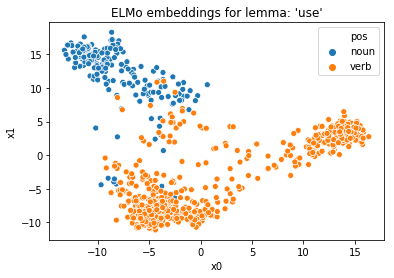

In [8]:
plot = sns.scatterplot(data=all_embeddings_df, x='x0', y='x1', hue='pos')
plot.set(title="ELMo embeddings for lemma: '%s'" % FIXED_LEMMA)
plt.show()

## Utility to inspect what ELMo is capturing

In [10]:
num_printed = 0
for sentence_ix in range(len(sampled_sentences)):
  token_list = sampled_sentences[sentence_ix]
  embeddings = embedder.elmo_embeddings[sentence_ix]
  for i in range(len(token_list)):
    if token_list[i]['lemma'] == FIXED_LEMMA:
      v = pca.transform(embeddings[i][np.newaxis, :])[0]
      if v[1] < -10: # <- Put whatever condition here
        print(v)
        print(' '.join([t['word'] for t in token_list]))
        print()
        num_printed += 1
  if num_printed > 10:
    break

[ -6.624563 -10.101494]
The second problem involving tense relates to whether you should use the present or the past tense in your writing .

[ -5.712993  -10.5483055]
Using our discussion of essay types above ( pp. 53 – 7 ) , decide which of the following types your essay is : DESCRIPTIVE If so , how is it organised : line by line ? thematically ? etc .

[ -5.0436287 -10.004247 ]
They use potassium cyanide commercially .

[ -4.095248 -10.162452]
A particularly severe test is to use the results to estimate the population of the area over the kilometre square grid given by the UK Ordnance Survey .

[ -5.3252697 -10.082996 ]
Excuse me just because the tape 's on there 's no need for you to use big words like prognosis .

[ -5.4322805 -10.076759 ]
She herself was going to use her own entrance .

[ -4.9081135 -10.949278 ]
Using the same information available for a sequential description , however , it is possible to organise an essay in more interesting ways .

[ -6.1341963 -10.320658 ]
Wh

## Cosine similarity between noun and verb usages

In [11]:
lemma_count_df = corpus.get_per_lemma_stats()

# Filter: must have at least [x] noun and [x] verb usages
lemma_count_df = lemma_count_df[(lemma_count_df['noun_count'] >= 100) & (lemma_count_df['verb_count'] >= 100)]
lemma_count_df = lemma_count_df.sort_values('total_count', ascending=False)
print('Remaining lemmas:', len(lemma_count_df))

Remaining lemmas: 109


In [13]:
lemma_count_df['nv_cosine_similarity'] = \
  lemma_count_df.apply(lambda row: embedder.get_nv_cosine_similarity(row.lemma), axis=1)

In [14]:
lemma_count_df[['lemma', 'noun_count', 'verb_count', 'majority_tag', 'nv_cosine_similarity']] \
  .sort_values('nv_cosine_similarity').head(8)

,lemma,noun_count,verb_count,majority_tag,nv_cosine_similarity
550,press,130,188,VERB,0.298041
1258,base,109,378,VERB,0.308212
1216,wave,402,120,NOUN,0.333697
1071,miss,320,410,VERB,0.352287
236,force,470,188,NOUN,0.362415
528,lead,107,716,VERB,0.447464
881,deal,191,315,VERB,0.447998
2439,design,246,153,NOUN,0.468243


In [15]:
lemma_count_df[['lemma', 'noun_count', 'verb_count', 'majority_tag', 'nv_cosine_similarity']] \
  .sort_values('nv_cosine_similarity', ascending=False).head(8)

,lemma,noun_count,verb_count,majority_tag,nv_cosine_similarity
2554,sleep,171,291,VERB,0.869839
10,matter,572,294,NOUN,0.851477
194,mind,736,620,NOUN,0.843908
149,go,293,13786,VERB,0.836792
969,doubt,261,132,NOUN,0.827440
2454,drink,456,315,NOUN,0.815713
3374,walk,144,914,VERB,0.810991
3079,care,403,249,NOUN,0.796855


/scratch/gobi1/wgao/anaconda-pkgs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


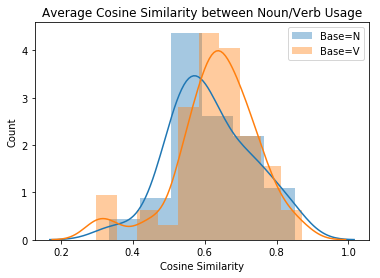

In [16]:
plot = sns.distplot(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity, label='Base=N')
plot = sns.distplot(lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity, label='Base=V')
plt.legend()
plot.set(title="Average Cosine Similarity between Noun/Verb Usage",
         xlabel="Cosine Similarity", ylabel="Count")
plt.show()

In [17]:
# T-test of difference in mean
import scipy.stats
scipy.stats.ttest_ind(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity,
                      lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity)

Ttest_indResult(statistic=-0.8181197461307498, pvalue=0.41510700142187706)